In [6]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
from matplotlib import style
style.use('fivethirtyeight')

In [ ]:
data_dir = 'gtsrb-german-traffic-sign'
train_path = 'gtsrb-german-traffic-sign/Train'
test_path = 'gtsrb-german-traffic-sign/Test'
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [8]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [9]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

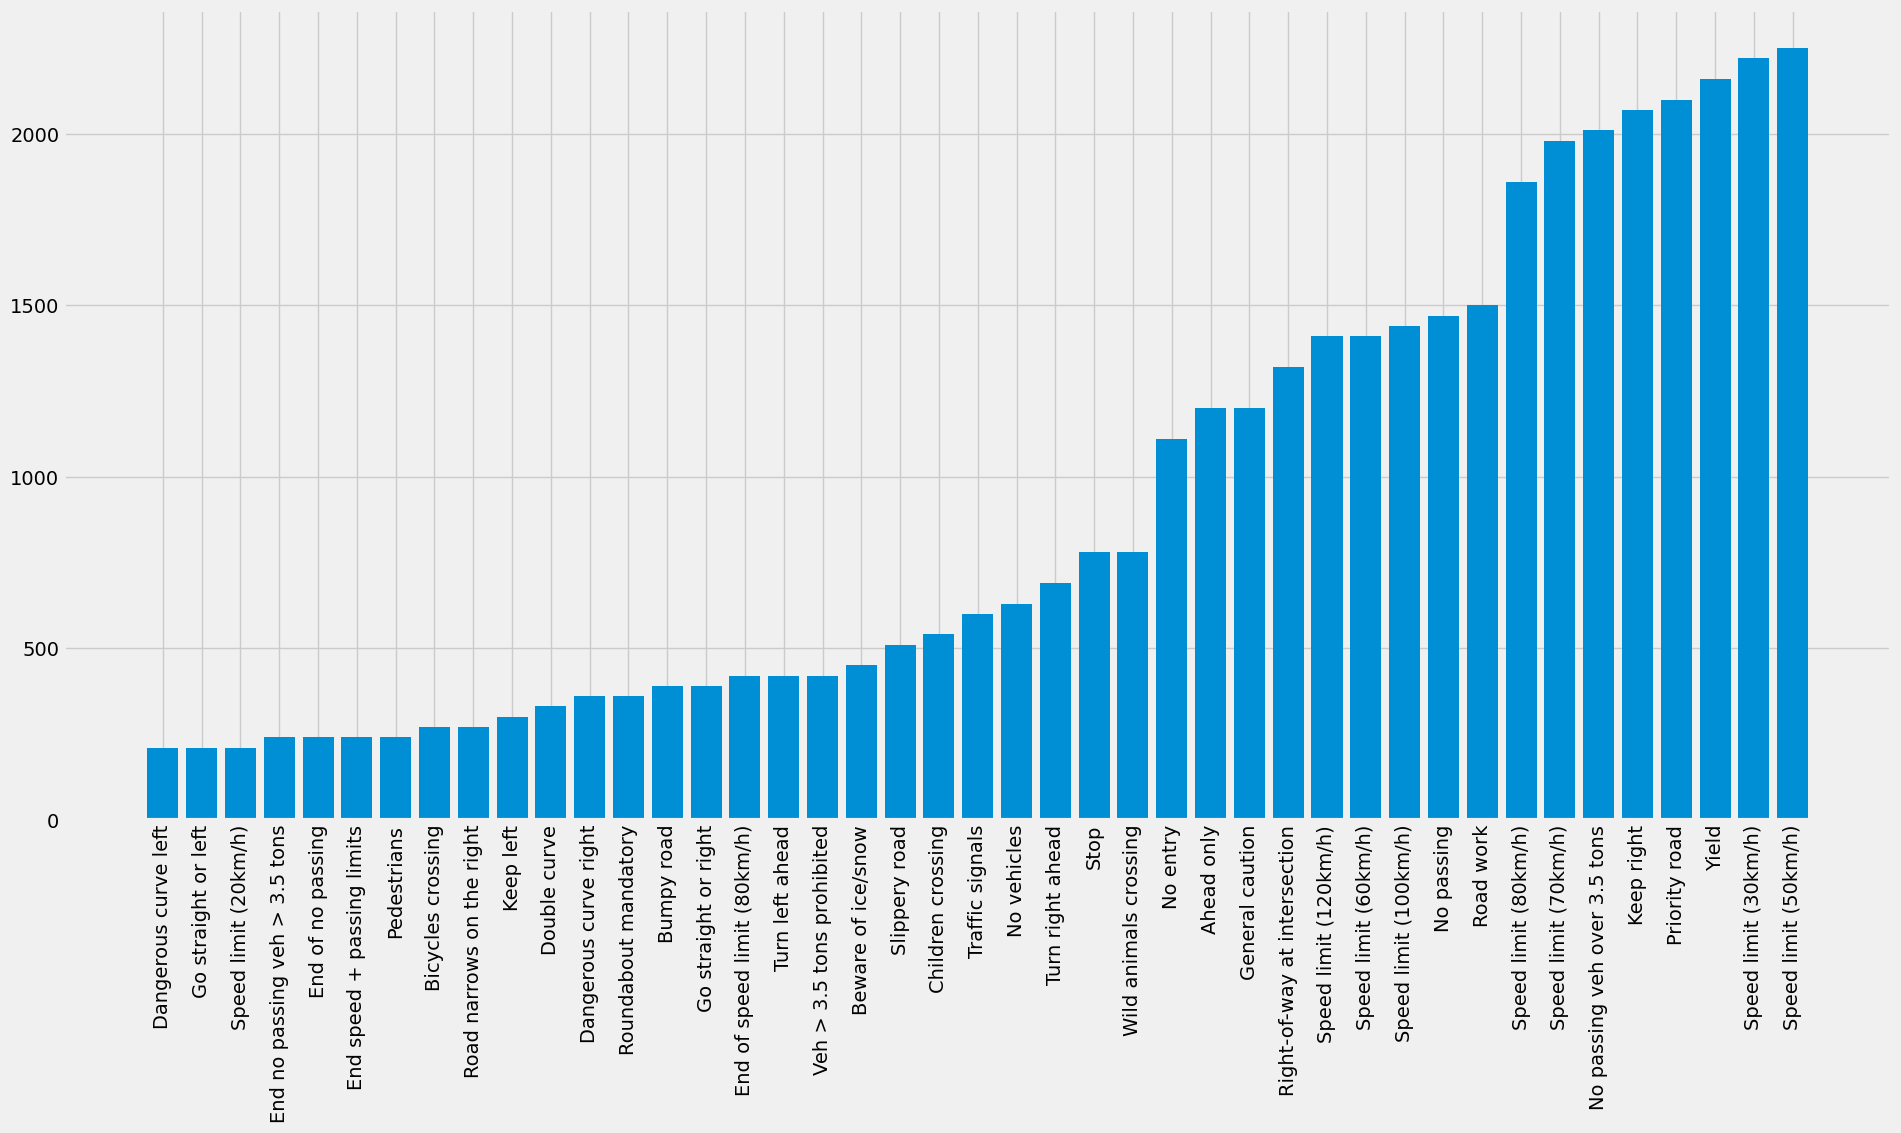

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset 
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting 
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

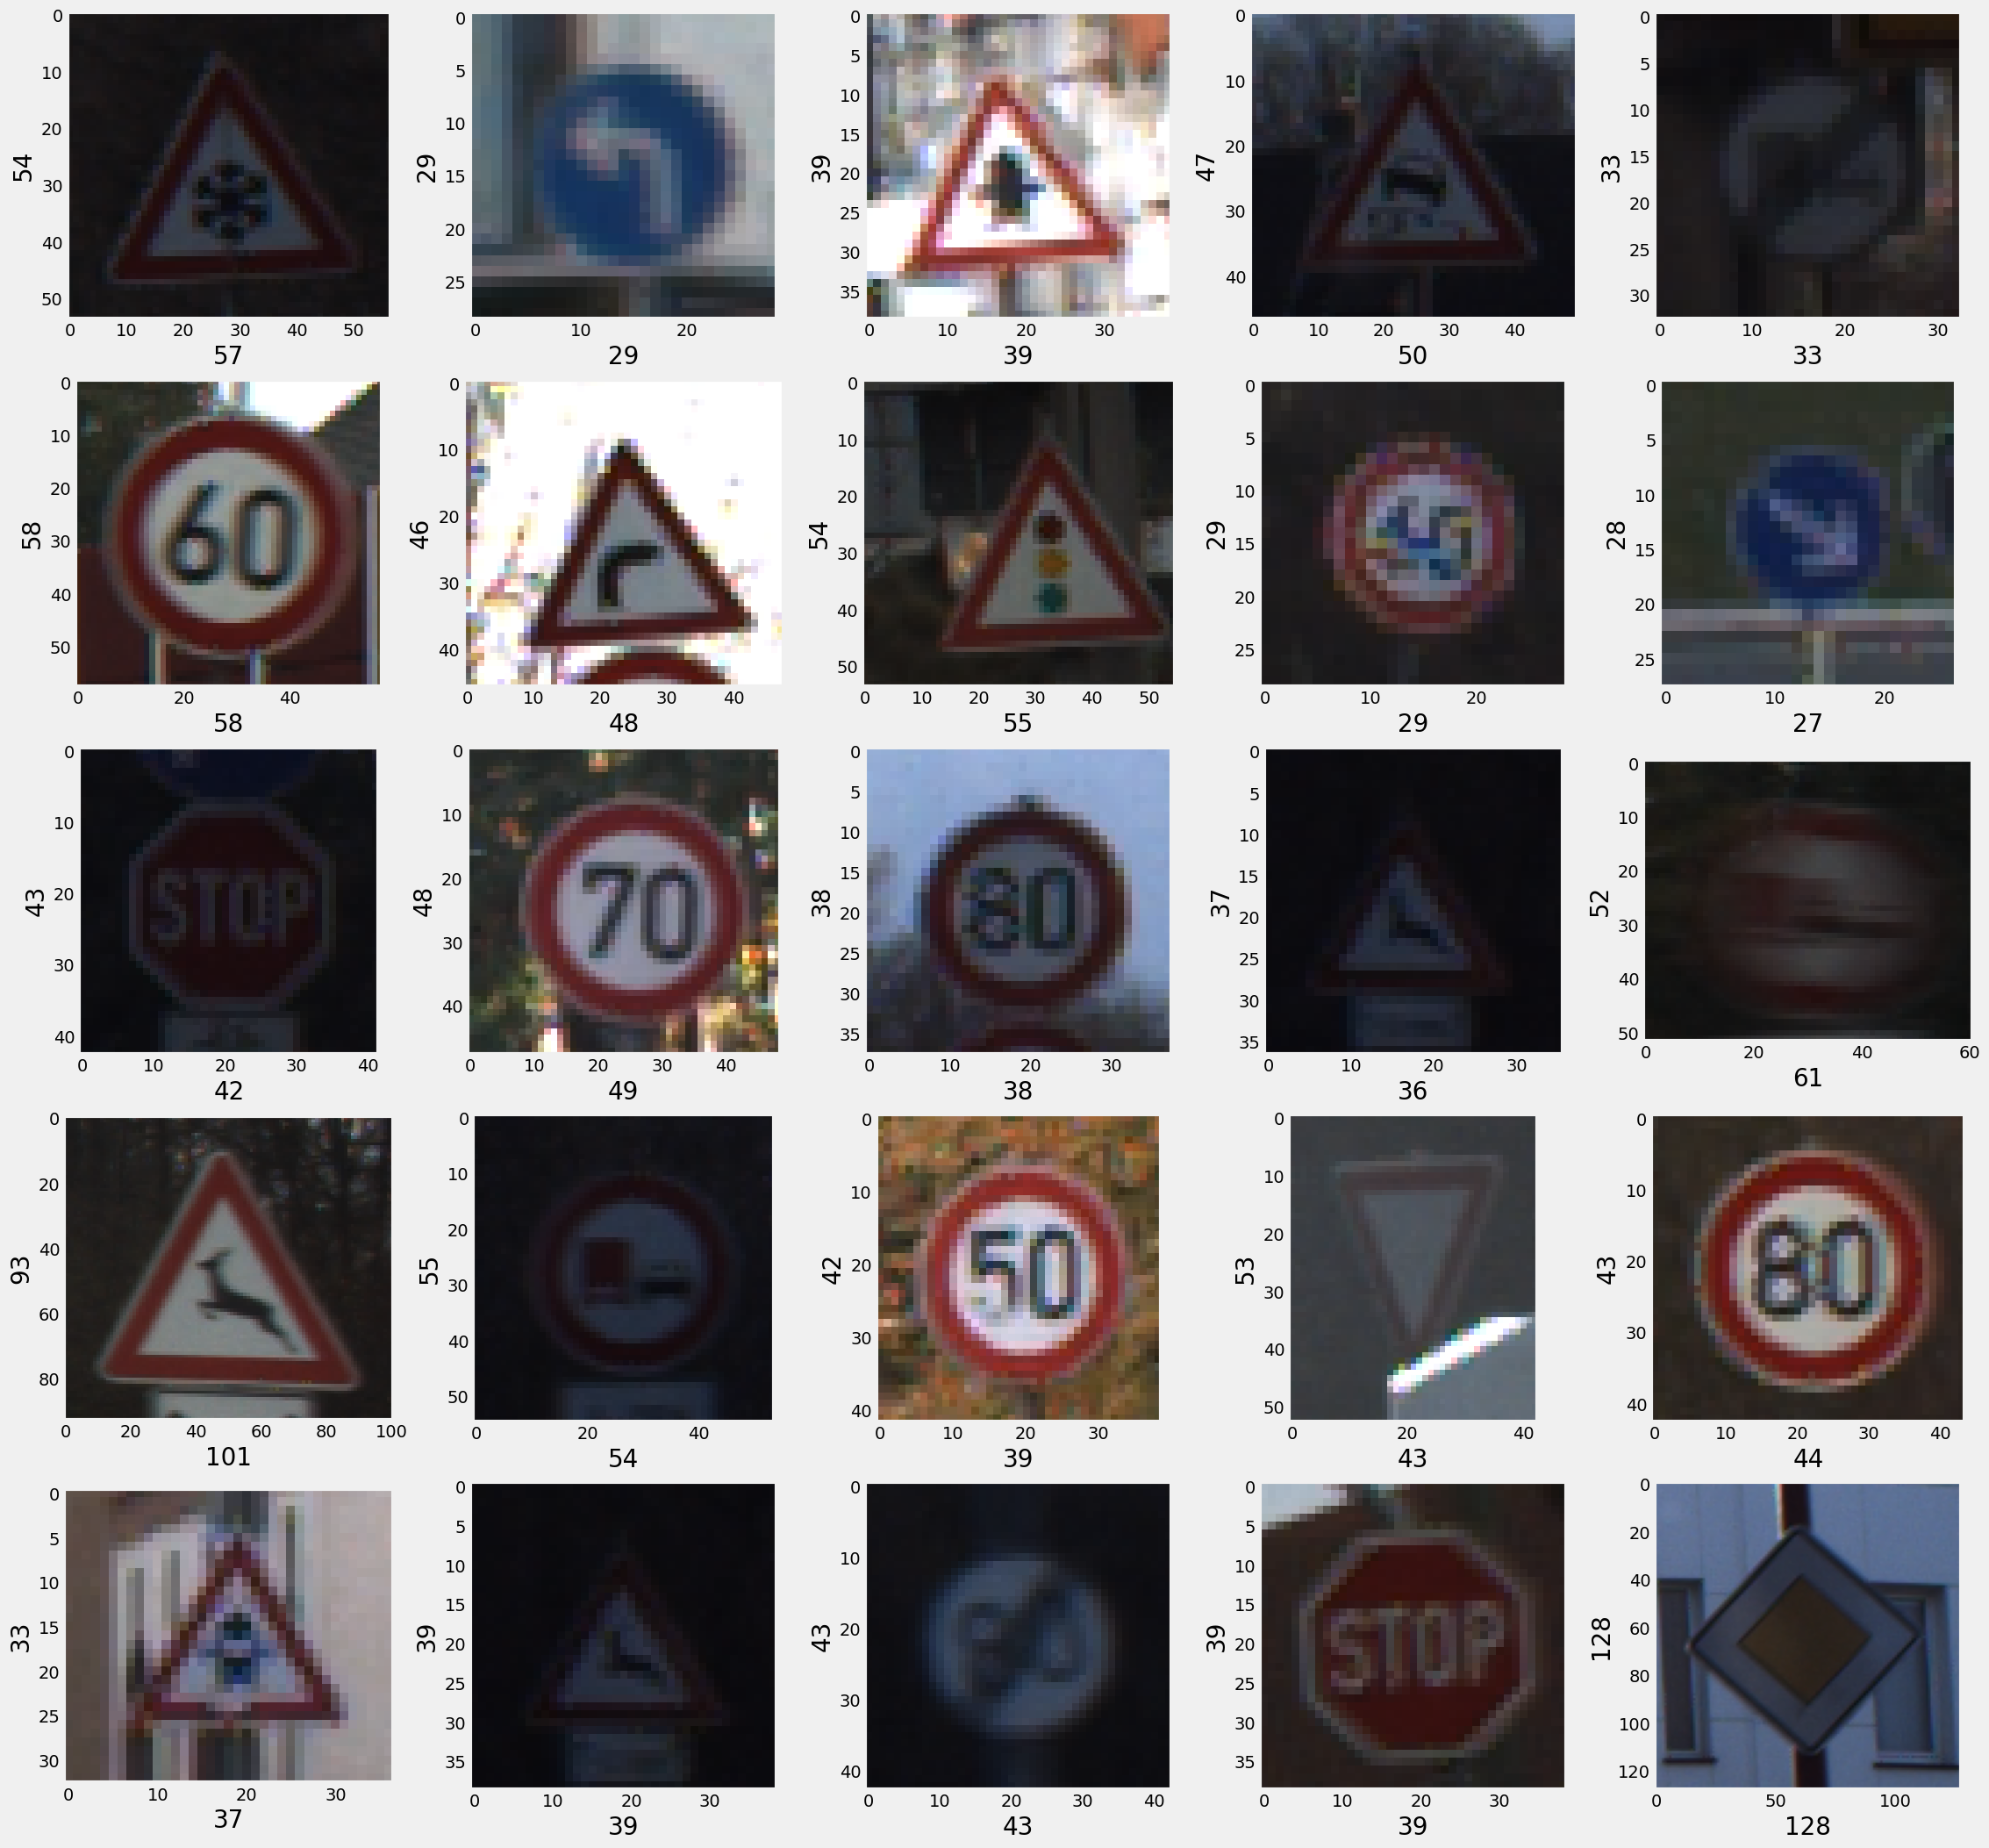

In [ ]:
#visualizing  images
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)
    plt.ylabel(rand_img.shape[0], fontsize = 20)

In [12]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [13]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

In [14]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [15]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, channels)),  

    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax') 
])

In [17]:
lr = 0.001
epochs = 50

opt = Adam(learning_rate=lr)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
aug = ImageDataGenerator(
    rotation_range=50,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest"
)

history = model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=epochs,
    validation_data=(X_val, y_val)
)

C:\Users\altam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 50s 51ms/step - accuracy: 0.3643 - loss: 2.6039 - val_accuracy: 0.9117 - val_loss: 0.2821
Epoch 2/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 43s 50ms/step - accuracy: 0.8148 - loss: 0.6069 - val_accuracy: 0.9671 - val_loss: 0.1069
Epoch 3/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9041 - loss: 0.3145 - val_accuracy: 0.9558 - val_loss: 0.1444
Epoch 4/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.9282 - loss: 0.2293 - val_accuracy: 0.9801 - val_loss: 0.0640
Epoch 5/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 44s 51ms/step - accuracy: 0.9375 - loss: 0.2062 - val_accuracy: 0.9901 - val_loss: 0.0324
Epoch 6/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9504 - loss: 0.1669 - val_accuracy: 0.9894 - val_loss: 0.0388
Epoch 7/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9564 - loss: 0.1479 - val_accuracy: 0.9927 - val_loss: 0.0224
Epoch 8/50
858/858 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9605 - loss: 0.1266 - 

In [ ]:
model.save("traffic_sign_model.h5")
print("Model saved successfully as 'traffic_sign_model.h5'.")


Model saved successfully as 'traffic_sign_model.h5'.


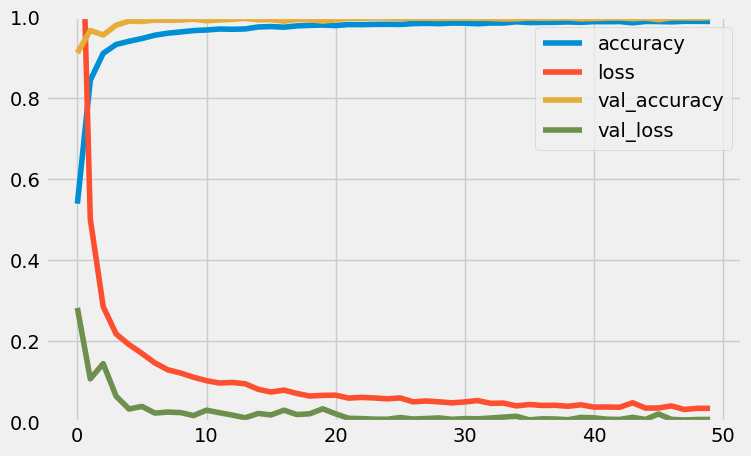

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show() 


In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

if len(X_test.shape) == 3: 
    X_test = np.expand_dims(X_test, axis=-1)

pred = np.argmax(model.predict(X_test), axis=1)


print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Test Data accuracy:  97.458432304038


In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)


<Axes: >

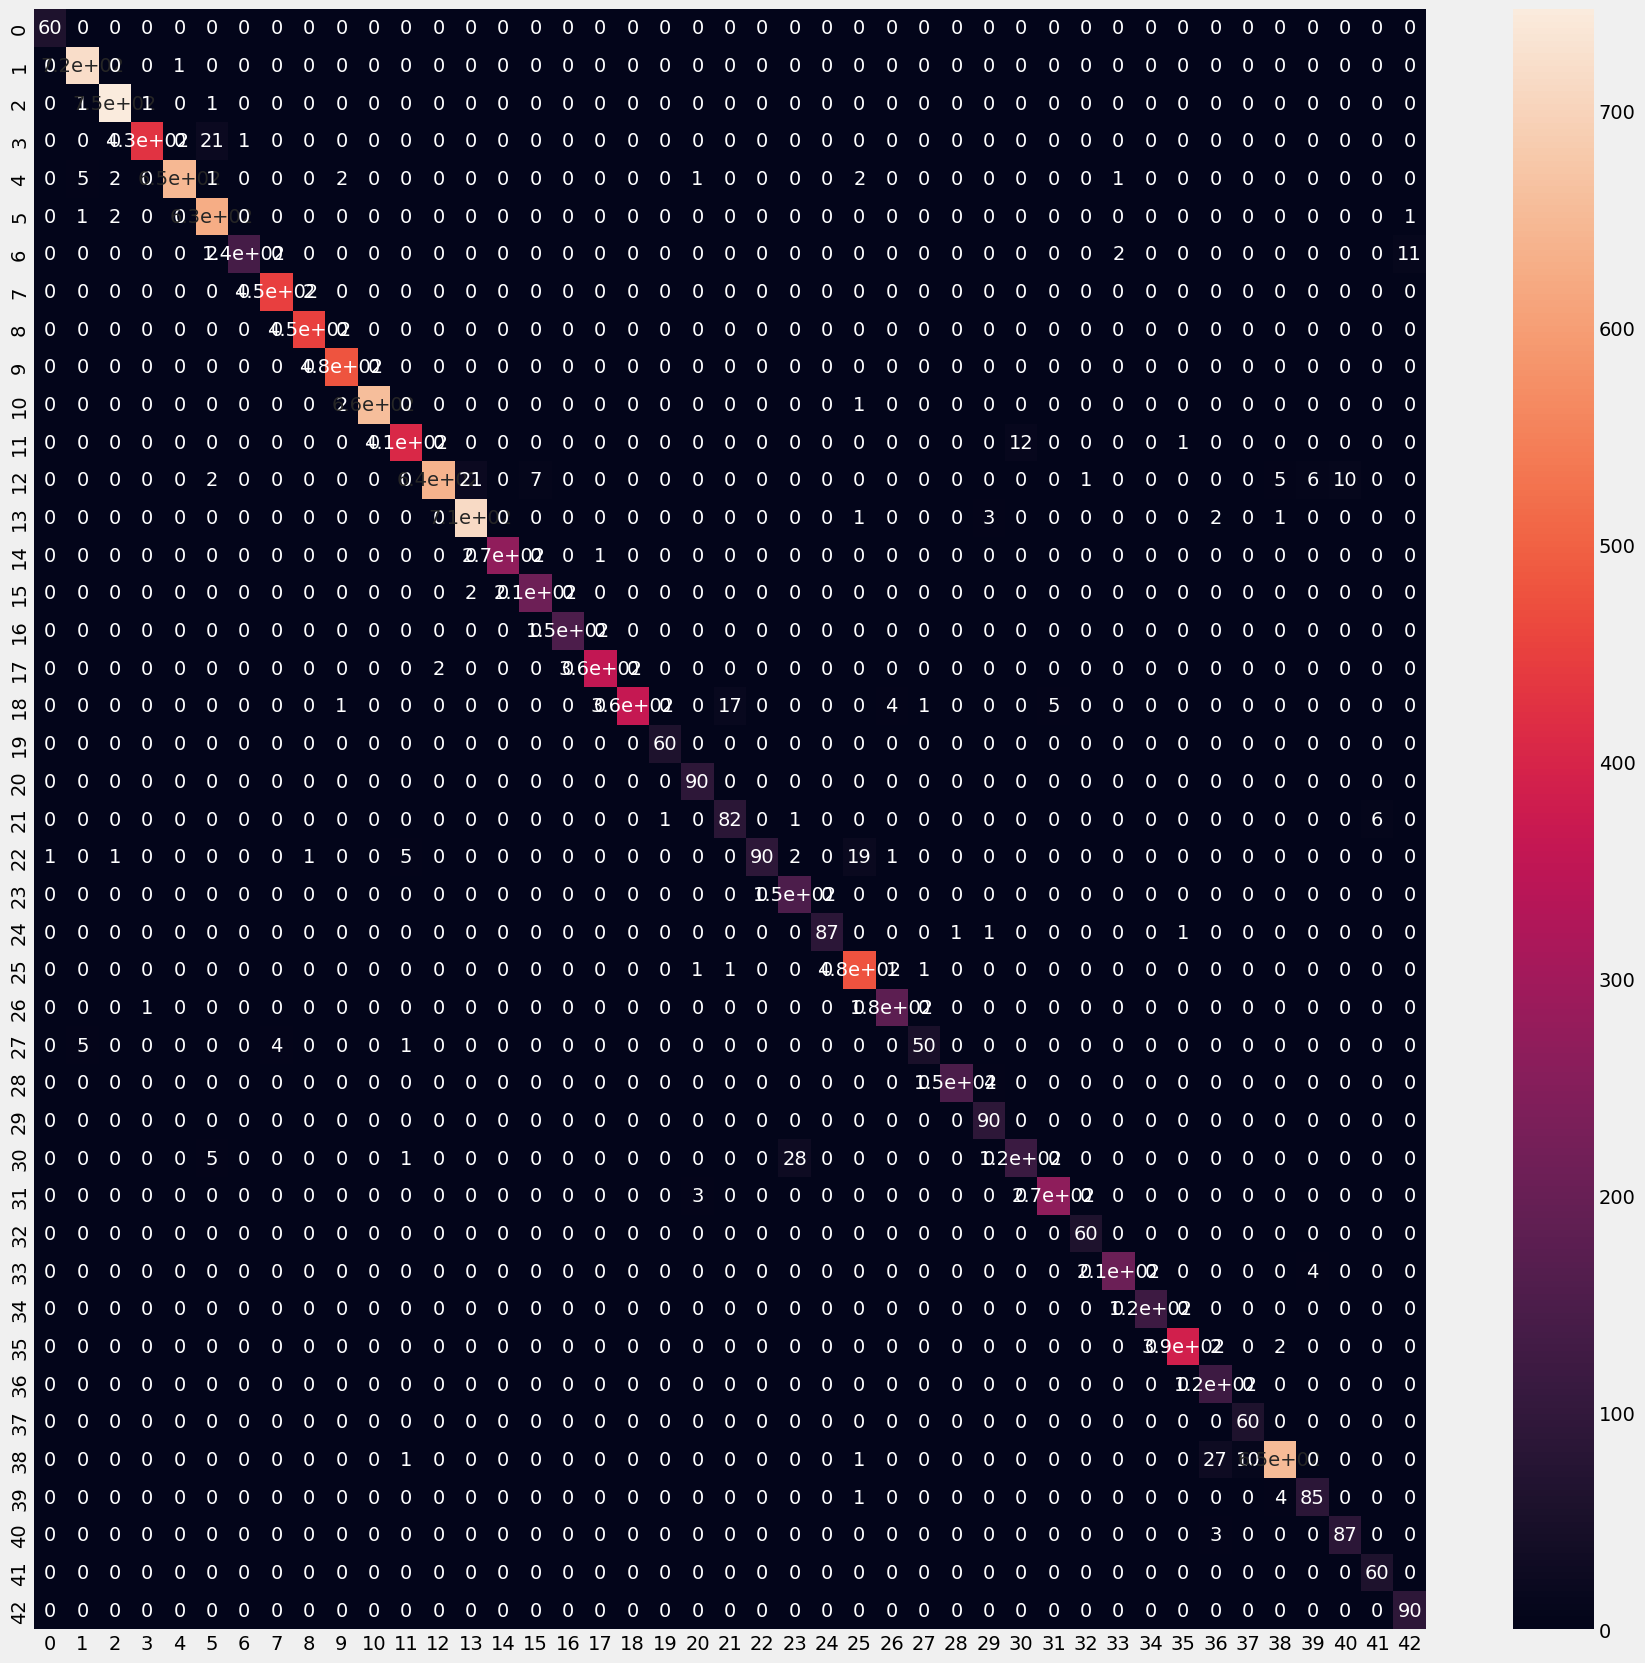

In [29]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      1.00      0.99       720
           2       0.99      1.00      0.99       750
           3       1.00      0.95      0.97       450
           4       1.00      0.98      0.99       660
           5       0.95      0.99      0.97       630
           6       0.99      0.90      0.94       150
           7       0.99      1.00      0.99       450
           8       0.99      1.00      1.00       450
           9       0.99      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       0.98      0.97      0.97       420
          12       1.00      0.92      0.96       690
          13       0.97      0.99      0.98       720
          14       1.00      1.00      1.00       270
          15       0.97      0.99      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

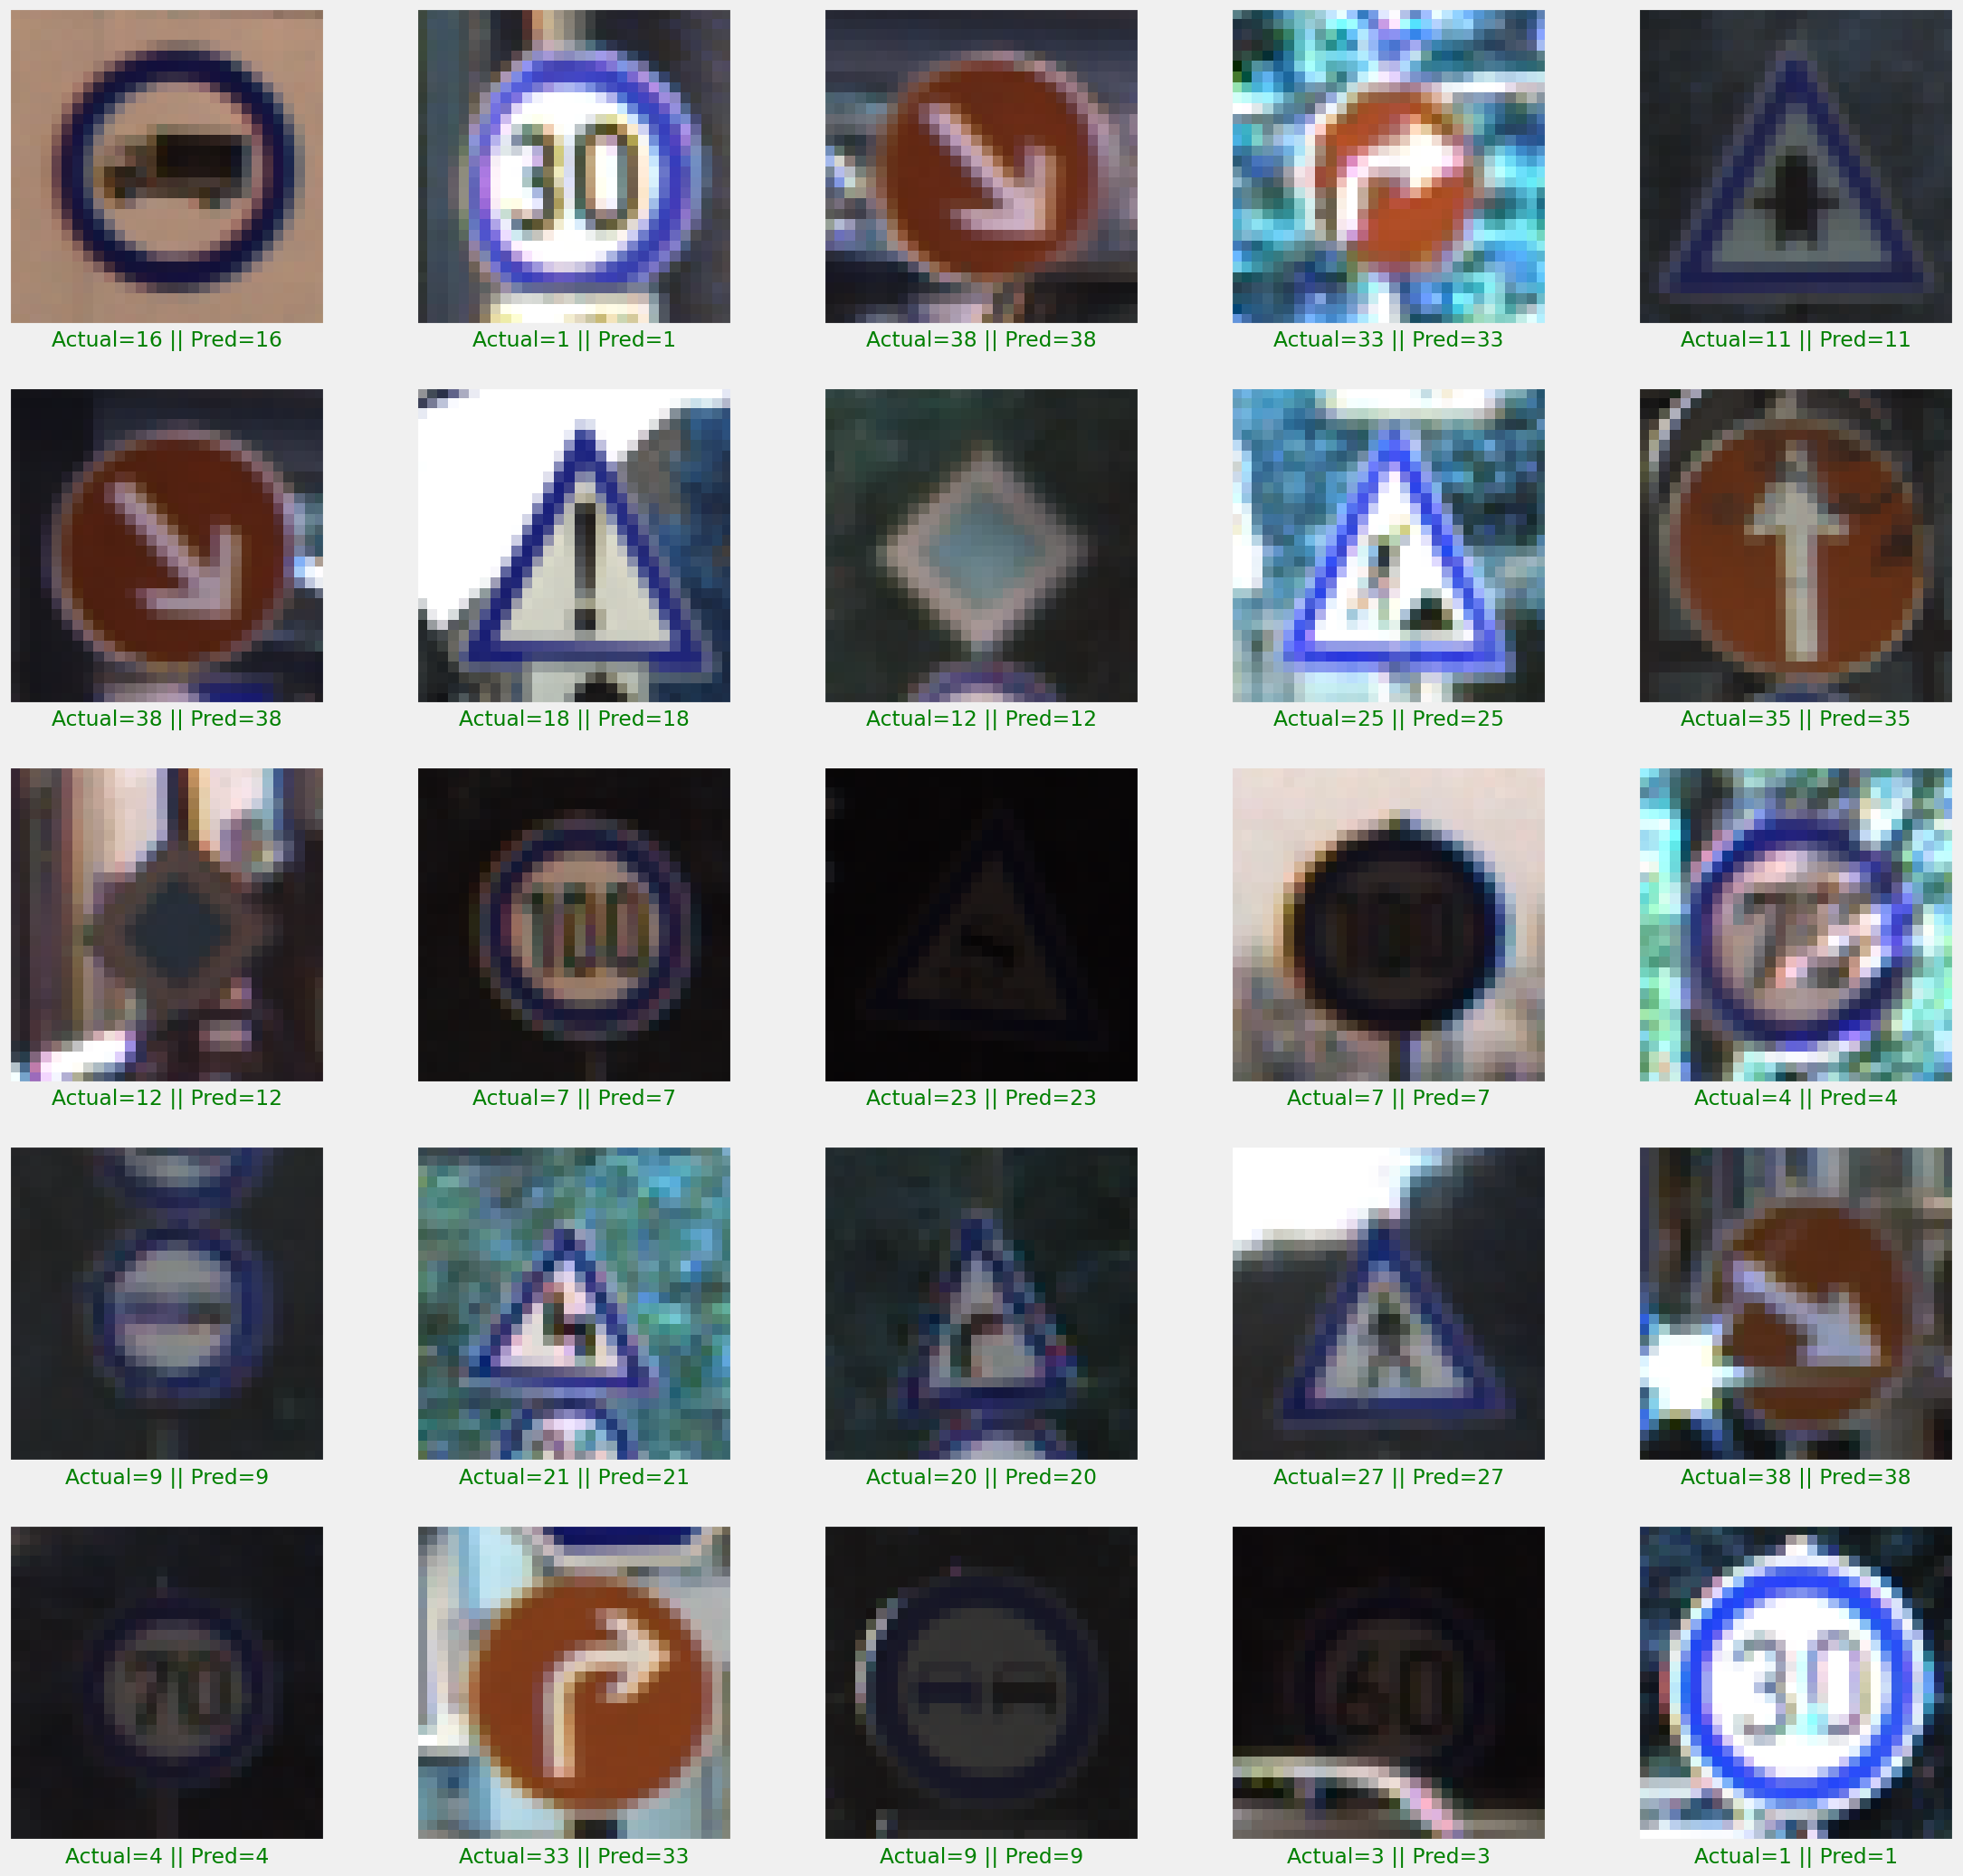

In [31]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()